In [ ]:
import datasets
# The code below is needed for using Google Colab, so un comment this if that is what you're using

import nltk
nltk.download('punkt')

# The code below is also needed for using Google Colab
# BEFORE executing this, you must place the mingpt folder supplied in the assignment
# your google drive, within the folder "Colab Notebooks"
#
# It mounts and changes into the folder that contains mingpt, which you must upload to google drive
# So un-comment it if you've uploaded mingpt to your google drive, into the  "Colab Notebooks" folder

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ECE\ 1786/1786A4

In [1]:
import torch
import numpy as np

from nltk.tokenize import sent_tokenize

from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from mingpt.bpe import BPETokenizer
from mingpt.utils import set_seed
set_seed(1234)
"""
Prepare the dataset to train the Language Model (LM)
This implementation splits the sentences and so doesn't create training
examples that cross sentences.

This code is set so that it uses one of two possible datasets, which were also used in Assignment 1:
SmallSimpleCorpus.txt or LargerCorpus.txt

Arguments:
            ds_choice: str. "small" or "large". (i.e. selects which of the two datasets)
            split: str. "train" or "test".
            truncation: int. If -1: no truncation on sentences. Otherwise: truncate to this specific length.
"""

class LanguageModelingDataset(Dataset):

    def __init__(self, ds_choice="small", split="train", truncation=-1):

        base_path = "./"
        fn = {"small": "SmallSimpleCorpus.txt", "large": "LargerCorpus.txt"}
        self.ds_choice = ds_choice
        self.truncation = truncation  # int. If -1, then
        text = Path(base_path, fn[ds_choice]).read_text(encoding='utf-8')
        if ds_choice == "large":
            # Remove the newline char in the middle of sentences
            # The "paragraph splitting" newlines appear to be \n\n -- remove the duplications there
            text = text.replace("\n\n", "$$^^$$").replace("\n", " ").replace("$$^^$$", "\n")
        sentences = sent_tokenize(text)

        # Train / test split
        train, val = train_test_split(sentences, test_size=0.2, shuffle=False)
        if split == "train":
            raw_data = train
        else:
            raw_data = val

        # Tokenize
        self.tokenizer = BPETokenizer()
        self.data = []  # List of 1-d pytorch tensor
        for sent in raw_data:
            tokenized = self.tokenizer(sent).view(-1)  # pytorch tensor
            if truncation >= 0:
                self.data.append(tokenized[:truncation])
            else:
                self.data.append(tokenized)
            #print(tokenized)
        # Count some items
        self.max_sentence_length = np.max([len(d) for d in self.data])

    def __len__(self):
        return len(self.data)

    def get_vocab_size(self):
        """
        We have to set this to the max vocab size (i.e., that decided by the BPE tokenizer),
        but actually, only a small number of vocab is used, especially for the small text.
        """
        return 50257

    def __getitem__(self, idx):
        """
        The output should be a tuple x and y, both as pytorch tensors.
        Please refer to the `run()` method in the mingpt/trainer.py script for
        how the x and y are going to be used.
        """
        x = self.data[idx][:-1]
        y = self.data[idx][1:]
        return (x, y)

    def get_block_size(self):
        """
        block_size is the size at which lines are truncated to ensure they are equal-length.
        """
        return self.max_sentence_length

# Instantiate the Training Dataset
#train_dataset = LanguageModelingDataset(ds_choice="small", split="train")  # use this for the short corpus
train_dataset = LanguageModelingDataset(ds_choice="large", split="train", truncation=512) #use this for long

# Instantiate a Validation Dataset (this is only really needed for the fine-tune task, not the LM task)
#val_dataset = LanguageModelingDataset(ds_choice="small", split="validation")
val_dataset = LanguageModelingDataset(ds_choice="large", split="validation", truncation=512)

In [2]:
import datasets
from sklearn.model_selection import train_test_split
sst=datasets.load_dataset("glue", "sst2")
print(sst["train"][1])
data=sst["train"][0:1200]
X=data['sentence']
Y = data['label']
print(type(X))
print(X[2])

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=None, random_state=42)
diff=sum(Y_train)-(sum(Y_train)+sum(Y_test))*0.8
if diff<1:
    print("no need to stratify!")

{'sentence': 'contains no wit , only labored gags ', 'label': 0, 'idx': 1}
<class 'list'>
that loves its characters and communicates something rather beautiful about human nature 
no need to stratify!


In [3]:
class ClassifierDataset(Dataset):

    def __init__(self,data,label, truncation=-1):

        for i in data:
            sentences = sent_tokenize(i)

        # Tokenize
        self.tokenizer = BPETokenizer()
        self.data = []  # List of 1-d pytorch tensor
        self.label = []
        for sent in data:
            tokenized = self.tokenizer(sent).view(-1)  # pytorch tensor
            self.data.append(tokenized)
        for lab in label:
            self.label.append([torch.tensor(lab).float(),torch.tensor(1-lab).float()])
        # Count some items
        try:
            self.max_sentence_length = np.max([len(d) for d in self.data])
            #ValueError: zero-size array to reduction operation maximum which has no identity
        except:
            pass

    def __len__(self):
        return len(self.data)

    def get_vocab_size(self):
        """
        We have to set this to the max vocab size (i.e., that decided by the BPE tokenizer),
        but actually, only a small number of vocab is used, especially for the small text.
        """
        return 50257

    def __getitem__(self, idx):
        """
        The output should be a tuple x and y, both as pytorch tensors.
        Please refer to the `run()` method in the mingpt/trainer.py script for
        how the x and y are going to be used.
        """
        x = self.data[idx]
        y = self.label[idx]
        return (x, y)

    def get_block_size(self):
        """
        block_size is the size at which lines are truncated to ensure they are equal-length.
        """
        return self.max_sentence_length

# Instantiate the Training Dataset
#train_dataset = LanguageModelingDataset(ds_choice="large", split="train", truncation=512) #use this for long
train_dataset = ClassifierDataset(X_train,Y_train, truncation=512)
# Instantiate a Validation Dataset (this is only really needed for the fine-tune task, not the LM task)
val_dataset = ClassifierDataset(X_test,Y_test, truncation=512)
print(train_dataset.get_block_size())

53


In [40]:
def lm_collate_fn(batch, device):
    x = [item[0] for item in batch]  # List (len B) of varying lengths
    y = [item[1] for item in batch]  # List (len B) of the same lengths as x
    maxlen = max([len(s) for s in x])
    maxen=512#to set make it align with LM
    padded_x = []
    for sx in x:
        padded_x.append(torch.cat([sx, torch.ones(maxlen - len(sx))]))
    return torch.stack(padded_x).long().to(device), torch.tensor(y)

# Print out an example of the data - this is processed more once it reaches lm_collate_fn (above)
x,y = train_dataset[5]
print(x, y)
print("X: ",train_dataset.tokenizer.decode(x))
print("Y: ",y)
from mingpt.model import GPT

model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = train_dataset.get_vocab_size()
model_config.block_size = 512#train_dataset.get_block_size()
model_config.n_classification_class = 2
model = GPT(model_config)
# Create a Trainer object and set the core hyper-parameters
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 1e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 100000  # For small corpus: 3000 iterations is plenty. For large corpus: 100000 iterations is needed
train_config.num_workers = 0
train_config.batch_size = 4    # For small corpus, batch size of 4 is fine.  For large corpus use 16
trainer = Trainer(train_config, model, train_dataset, val_dataset,downstream_finetune=True, collate_fn=lm_collate_fn)

tensor([10134,   262,  8754,    12, 45525,  1254,   286,   257,  3931,    12,
        16544,  7401,   905,  1058, 37205,  3194,   837,   739,   260,   258,
          945,   276,   837, 40647, 37515,   290,   220]) [tensor(0.), tensor(1.)]
X:  has the thrown-together feel of a summer-camp talent show : hastily written , underrehearsed , arbitrarily plotted and 
Y:  [tensor(0.), tensor(1.)]
number of parameters: 2.52M
running on device cuda


In [41]:
if True:
    modelsavename= "mint.pt"
    # The code below shows how to reload the model from the saved file; is useful things that take long to train
    model.load_state_dict(torch.load(modelsavename))

In [42]:
import matplotlib.pyplot as plt
# This function is called at the end of every batch in training
# and is used to report the amount of time per 100 batches, and the loss at that point
loss_train=np.zeros(trainer.config.max_iters)
loss_val=np.zeros(trainer.config.max_iters)
def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
    loss_train[trainer.iter_num]=trainer.loss.item()
    loss_val[trainer.iter_num]=trainer.val_loss.item()
trainer.set_callback('on_batch_end', batch_end_callback)

# Train!
trainer.run()

iter_dt 0.00ms; iter 0: train loss 19.48191
iter_dt 9.03ms; iter 100: train loss 3.32920
iter_dt 8.05ms; iter 200: train loss 1.98931
iter_dt 8.95ms; iter 300: train loss 0.85473
iter_dt 11.01ms; iter 400: train loss 0.28399
iter_dt 8.98ms; iter 500: train loss 0.74150
iter_dt 9.00ms; iter 600: train loss 0.84049
iter_dt 9.66ms; iter 700: train loss 0.35652
iter_dt 10.01ms; iter 800: train loss 0.73660
iter_dt 10.00ms; iter 900: train loss 0.45420
iter_dt 25.28ms; iter 1000: train loss 0.34762
iter_dt 23.20ms; iter 1100: train loss 0.68618
iter_dt 19.98ms; iter 1200: train loss 0.44779
iter_dt 8.00ms; iter 1300: train loss 0.37161
iter_dt 9.91ms; iter 1400: train loss 0.21037
iter_dt 10.37ms; iter 1500: train loss 0.31186
iter_dt 28.04ms; iter 1600: train loss 0.14913
iter_dt 9.14ms; iter 1700: train loss 0.41132
iter_dt 10.02ms; iter 1800: train loss 0.13296
iter_dt 8.49ms; iter 1900: train loss 0.21360
iter_dt 9.01ms; iter 2000: train loss 0.21865
iter_dt 7.98ms; iter 2100: train los

Final test accuracy: 0.7041666666666667
[0.00290389]
[0.29625264]


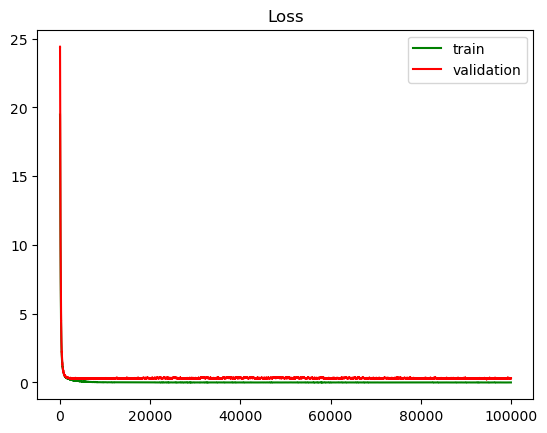

In [43]:
#smoothing the curve
for i in range (trainer.config.max_iters-1):
    loss_train[i+1]=loss_train[i]*0.99+loss_train[i+1]*0.01
    loss_val[i+1]=loss_val[i]*0.99+loss_val[i+1]*0.01


#plotting section
fig, splot = plt.subplots(1)
domain = np.arange(trainer.config.max_iters)
splot.plot(domain, loss_train, 'g',label="train")
splot.plot(domain, loss_val, 'r',label="validation")
splot.legend()
splot.title.set_text("Loss")
correct=0
for i in range (len(val_dataset)):
    x,y = val_dataset[i]
    generated_logits = trainer.model(x[None,:].to(trainer.device), finetune_classify=True)
    pred=(generated_logits[0][0][0]>generated_logits[0][0][1]).item()
    target=(y[0]>y[1]).item()
    if pred==target:
        correct+=1

print("Final test accuracy:",correct/len(val_dataset))
print(loss_train[-1:])
print(loss_val[-1:])

In [36]:
model.to(trainer.device)
# store the saved model in a file, so can re-use later
modelsavename= "mint_classifier.pt"  # change the name here to save in a specific file (and restore below)
with open(modelsavename, "wb") as f:
    torch.save(trainer.model.state_dict(), f)